# Preparing the environment for EDA

In [1]:
# Imports of Models & libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import squarify
import math


from datetime import datetime
from statsmodels.formula.api import ols
from sklearn import linear_model
from pywaffle import Waffle
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter
from nltk import PorterStemmer
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
outer_london = pd.read_csv('Outer_London.csv')

In [3]:
# View Metadata
outer_london.info()

# 375659 rows of data with top row as header

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375660 entries, 0 to 375659
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Survey wave (year)        375660 non-null  int64 
 1   Site ID                   375660 non-null  object
 2   Location                  375660 non-null  object
 3   Survey date               374492 non-null  object
 4   Weather                   374692 non-null  object
 5   Time                      375660 non-null  object
 6   Period                    375660 non-null  object
 7   Direction                 375660 non-null  object
 8   Start hour                375660 non-null  int64 
 9   Start minute              375660 non-null  int64 
 10  Number of male cycles     375660 non-null  int64 
 11  Number of female cycles   375660 non-null  int64 
 12  Number of unknown cycles  375660 non-null  int64 
 13  Total cycles              375660 non-null  int64 
dtypes: i

In [4]:
# Look at random sample of data
outer_london.sample(5)

,Survey wave (year),Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of male cycles,Number of female cycles,Number of unknown cycles,Total cycles
137545,2017,OUTCY173,Upminster Road North,"ven, 19/05/17",Dry,0815 - 0830,AM peak (07:00-10:00),Westbound,8,15,0,0,0,0
84970,2016,OUTCY213,Carter Drive,"jeu, 12/05/16",Dry,1630 - 1645,PM peak (16:00-19:00),Southbound,16,30,0,0,0,0
155940,2017,OUTCY317,Morley Road,"lun, 19/06/17",Dry,1500 - 1515,Inter-peak (10:00-16:00),Northbound,15,0,0,0,0,0
303613,2020,OUTCY166,Cudham Lane North,"mar, 29/09/20",Dry,2115 - 2130,Evening (19:00-22:00),Westbound,21,15,0,0,0,0
225155,2018,OUTCY407,Mayesbrook Park,"mer, 20/06/18",Dry,0645 - 0700,Early Morning (06:00-07:00),Eastbound,6,45,0,0,0,0


# Data Wrangling

In [5]:
# Rename columns to remove space in column names
outer_london.columns = outer_london.columns.str.replace(' ','_')

In [6]:
# Parse Dates correctly
# Remove French Day name in Survey Date 
outer_london["Survey_date"] = outer_london["Survey_date"].str.replace(r'\D+', '', regex=True)

# Convert to datetime format
outer_london['Survey_date'] = pd.to_datetime(outer_london.Survey_date)

# Define day of the week in English and add back as a column
outer_london['Day_of_week'] = outer_london['Survey_date'].dt.day_name()

In [7]:
# Pass Month & Season
# Pass Month
outer_london['month'] = outer_london['Survey_date'].dt.month

# Pass Season
# Create function for user defined seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
outer_london['season'] = outer_london['month'].apply(f)

In [8]:
# Check output
outer_london.sample(5)

,Survey_wave_(year),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_male_cycles,Number_of_female_cycles,Number_of_unknown_cycles,Total_cycles,Day_of_week,month,season
225431,2018,OUTCY409,Roding River path (Barking),2018-06-20,Dry,1145 - 1200,Inter-peak (10:00-16:00),Northbound,11,45,2,0,0,2,Wednesday,6.0,Summer
364307,2021,OUTCY361,Natal Road,2021-06-23,Dry,1545 - 1600,Inter-peak (10:00-16:00),Eastbound,15,45,0,0,0,0,Wednesday,6.0,Summer
291072,2020,OUTCY022,Leatherhead Road,2020-07-10,Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6,0,1,0,0,1,Friday,7.0,Summer
186221,2018,OUTCY102,Coombe Road,2018-06-28,Dry,1715 - 1730,PM peak (16:00-19:00),Southbound,17,15,7,0,0,7,Thursday,6.0,Summer
24223,2015,OUTCY190,Plaistow Lane,2015-02-06,Dry,1345 - 1400,Inter-peak (10:00-16:00),Northbound,13,45,0,1,0,1,Friday,2.0,Winter


In [9]:
# Check missing values
outer_london.isnull().sum()

# Relatively small number of missing values. 
# Drop the ones without survey date.

Survey_wave_(year)             0
Site_ID                        0
Location                       0
Survey_date                 1168
Weather                      968
Time                           0
Period                         0
Direction                      0
Start_hour                     0
Start_minute                   0
Number_of_male_cycles          0
Number_of_female_cycles        0
Number_of_unknown_cycles       0
Total_cycles                   0
Day_of_week                 1168
month                       1168
season                      1168
dtype: int64

In [10]:
# Drop rows if missing values in Survey_date column
outer_london = outer_london.dropna(subset=['Survey_date'])

In [11]:
# Recheck output
outer_london.isnull().sum()

# Can see only 312 rows where missing value from weather is uniquely missing.
# will retain for now and revisit when dealing with weather.

Survey_wave_(year)            0
Site_ID                       0
Location                      0
Survey_date                   0
Weather                     312
Time                          0
Period                        0
Direction                     0
Start_hour                    0
Start_minute                  0
Number_of_male_cycles         0
Number_of_female_cycles       0
Number_of_unknown_cycles      0
Total_cycles                  0
Day_of_week                   0
month                         0
season                        0
dtype: int64

In [12]:
# Drop rows where total cycles doesnt add up to number of male, female and unknown cycles
# Creating a column to add up the values
outer_london['Sum'] = outer_london['Number_of_male_cycles'] + outer_london['Number_of_female_cycles'] + outer_london['Number_of_unknown_cycles']

# Dropping rows where the column values dont add up 
outer_london = outer_london[outer_london.Total_cycles == outer_london.Sum]

# Look at output
outer_london.info()

# Only 1 row dropped where total didnt add up

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374491 entries, 0 to 375659
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Survey_wave_(year)        374491 non-null  int64         
 1   Site_ID                   374491 non-null  object        
 2   Location                  374491 non-null  object        
 3   Survey_date               374491 non-null  datetime64[ns]
 4   Weather                   374179 non-null  object        
 5   Time                      374491 non-null  object        
 6   Period                    374491 non-null  object        
 7   Direction                 374491 non-null  object        
 8   Start_hour                374491 non-null  int64         
 9   Start_minute              374491 non-null  int64         
 10  Number_of_male_cycles     374491 non-null  int64         
 11  Number_of_female_cycles   374491 non-null  int64         
 12  Nu

In [13]:
# Drop the redundant columns
outer_london.drop(['Sum', 'Start_hour', 'Start_minute', 'month'], axis=1)

,Survey_wave_(year),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Number_of_male_cycles,Number_of_female_cycles,Number_of_unknown_cycles,Total_cycles,Day_of_week,season
0,2015,OUTCY001,High Road Leyton,2015-06-26,Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,2,1,0,3,Friday,Summer
1,2015,OUTCY001,High Road Leyton,2015-06-26,Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,3,0,0,3,Friday,Summer
2,2015,OUTCY001,High Road Leyton,2015-06-26,Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,2,0,0,2,Friday,Summer
3,2015,OUTCY001,High Road Leyton,2015-06-26,Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,4,0,0,4,Friday,Summer
4,2015,OUTCY001,High Road Leyton,2015-06-26,Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,4,1,0,5,Friday,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375655,2021,OUTCY451,Thames Path (Lower Ham Road),2021-06-18,Wet,2045 - 2100,Evening (19:00-22:00),Southbound,1,0,0,1,Friday,Summer
375656,2021,OUTCY451,Thames Path (Lower Ham Road),2021-06-18,Wet,2100 - 2115,Evening (19:00-22:00),Southbound,2,0,0,2,Friday,Summer
375657,2021,OUTCY451,Thames Path (Lower Ham Road),2021-06-18,Wet,2115 - 2130,Evening (19:00-22:00),Southbound,0,0,0,0,Friday,Summer
375658,2021,OUTCY451,Thames Path (Lower Ham Road),2021-06-18,Wet,2130 - 2145,Evening (19:00-22:00),Southbound,0,0,0,0,Friday,Summer


In [14]:
# Count unique values in each column
for col in outer_london:
  print(col,": ", outer_london[col].nunique())

# More site ids vs location
# May imply multiple sites in same location. Need to check for double count.
# Survey period of over 7 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 123 types of weather needs to be discussed and trimmed with team

Survey_wave_(year) :  7
Site_ID :  451
Location :  431
Survey_date :  435
Weather :  123
Time :  64
Period :  5
Direction :  4
Start_hour :  16
Start_minute :  4
Number_of_male_cycles :  55
Number_of_female_cycles :  20
Number_of_unknown_cycles :  11
Total_cycles :  65
Day_of_week :  7
month :  12
season :  4
Sum :  65


In [15]:
# Explore the different types of Weather
print(outer_london.Weather.unique())

# Lots of overlaps for e.g. Rain & Wet, Dry/cold and dry Cold.
# Need to classify into much narrower streams. 

['Dry' 'Wet' 'Showers' 'Cloudy' 'Rain' 'Dry Chill' 'Sunny' 'Cloudy Sunny'
 'Sun Setting' 'Dry/cold' 'Dry Cold' 'Cold/sunny' 'Cold/cloudy'
 'Sunny Overcast' 'Sunny/cloudy' 'Dry Dark' 'Fine' 'Good' 'Dry Very Windy'
 'Wet/dry' 'Cloudy/rain/sunny' 'Cloudy + Sunny' 'Sunny + Cloudy'
 'Dry/sunny' 'Dry/windy' 'Wet/windy' 'Wet/v.windy' 'Fine + Dry'
 'Fine + Hot' 'Cloudy/sunny' 'Dry/dark' 'Dry/good' 'Fine/dry' 'Warm + Dry'
 'Windy' 'Bright + Cloudy' 'Dark/dry' 'Cloudy/dry' 'Cloudy + Rain'
 'Rain & Cloudy' 'Raining' 'Dry/mild' 'Cold' 'Partly Sunny' 'Rain/cloudy'
 'Cloudy/windy' 'Windy + Sunny' 'Sunsetting + Windy' 'Dark Cloudy'
 'Dark Dry' 'Bright' 'Dull' 'Heavy Rain' 'Intermittent Light Drizzle'
 'Heavy Shower' 'Light Rain' 'Dry Hot!!' 'Lt Rain' 'Heavy Shr'
 'Dry & Sunny' 'Dry/wet Road' 'Dry With Wet Road' 'Dry/wet' 'Dry & Sun'
 'Drizzle' 'Down Pour' 'Deluge' 'Wet/thunder' 'Dry & Mild' 'Hot'
 'Fine & Dry' nan 'Dry V. Cold!' 'Wet Hail' 'Heavy Showers' 'Shower'
 'Rain/hail' 'Rain Heavy Showers' 'S

In [16]:
# Replace some obvious duplications in Weather
# Rain
outer_london['Weather'] = outer_london['Weather'].replace(['Wet','Showers','Rain','Cloudy + Rain','Rain & Cloudy',
                                                          'Raining', 'Rain/cloudy','Wet/thunder','Light Showers',
                                                          'Rain/showers','W','Wey','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower',
                                                          'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)'],'Rain')

# Good
outer_london['Weather'] = outer_london['Weather'].replace(['Cloudy','Sunny Overcast Sunny','Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy with clear spells',
                                                          'Sunny Overcast', 'Sunny','Cloudy Sunny','Sun Setting','Good',
                                                           'Dry/sunny','Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry','Warm + Dry','D'],'Good')
# Damp
outer_london['Weather'] = outer_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle',
                                                           'Light Rain','Lt Rain','Drizzle','Intermittent Drizzle', 'Damp',
                                                           'Getting Dry','Dry & Wet','Dry/wet',],'Damp')


# Dangerous Conditions
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Chill','Dry/cold','Dry Cold','Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Wet/windy','Wet/v.windy','Wet Hail',
                                                           'Rain/hail','Foggy Wet','Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot','Dry (road Wet)'],
                                                          'Dangerous_Conditions')

# Replacing nan with 'Unknown'
outer_london.Weather = outer_london.Weather.fillna('Unknown')

# Consolidating "Unknown"
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry','Dark Dry'],'Unknown')

In [17]:
# Check output
print(outer_london.Weather.unique())

['Good' 'Rain' 'Dangerous_Conditions' 'Unknown' 'Damp']


# Basic Visualisations

## How has cycling evolved over time?


In [26]:
# Aggregate data by survey year
df= outer_london.groupby(['Survey_wave_(year)'], as_index=False)['Total_cycles'].sum()
df

,Survey_wave_(year),Total_cycles
0,2015,80039
1,2016,77676
2,2017,85521
3,2018,91966
4,2019,82117
5,2020,74924
6,2021,99067


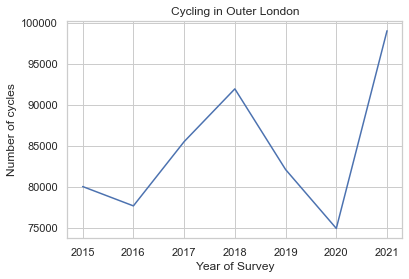

In [27]:
# Create the line chart
plt.plot(df['Survey_wave_(year)'], df['Total_cycles'])

# Adding the aesthetics
plt.title("Cycling in Outer London")
plt.xlabel('Year of Survey')
plt.ylabel('Number of cycles')

# Show the plot
plt.show()

## Does time of the day matter?

In [28]:
# Aggregate by time of day

df= outer_london.groupby(['Period'], as_index=False)['Total_cycles'].sum()
df.sort_values('Total_cycles', inplace = True)

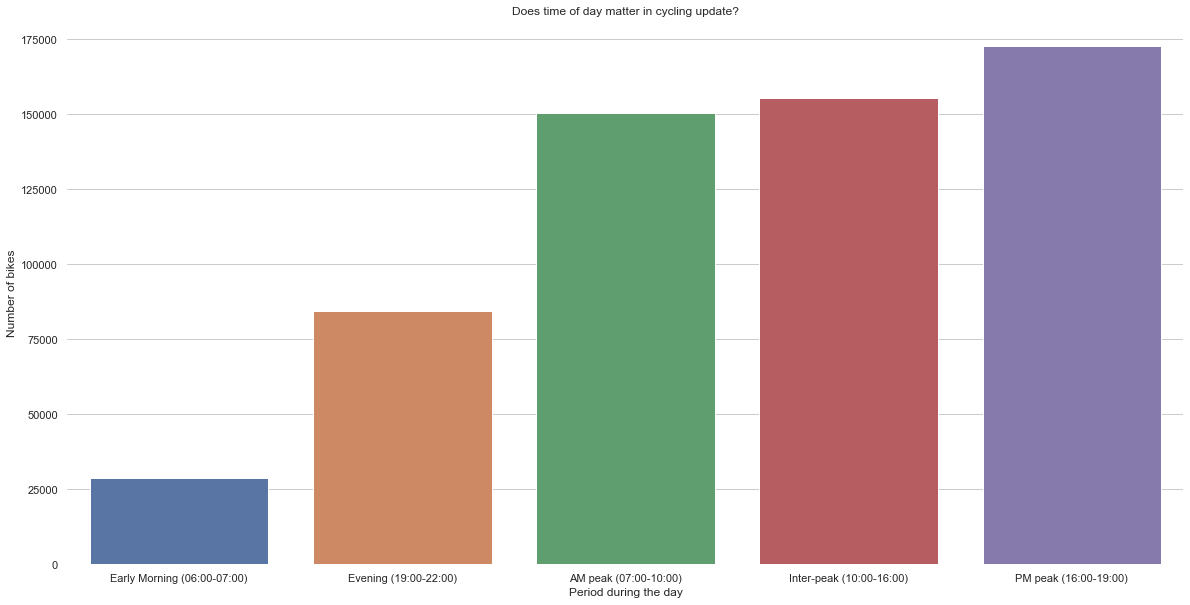

In [29]:
# Chart to view time of day with highest cycling count
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (20,10))

g=sns.barplot(x = df['Period'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Period during the day")
g.set_title('Does time of day matter in cycling update?')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Interpeak data highest in terms of count
# Sum shows different story

## Do Seasons make a difference?

In [30]:
# Aggregate data by Weather
df= outer_london.groupby(['season'], as_index=False)['Total_cycles'].sum()
df

,season,Total_cycles
0,Autumn,121084
1,Spring,222693
2,Summer,207195
3,Winter,40338


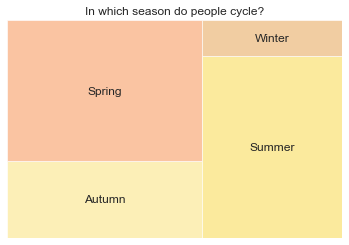

In [31]:
# Plotting a treemap
# Colour Palette
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']

# Set Plot Style
sns.set_style(style="whitegrid") 

# Setting the variable
sizes= df["Total_cycles"].values
label=df["season"]

# Setting the styles
squarify.plot(sizes=sizes, label=label, alpha=0.6,color=colors).set(title='In which season do people cycle?')
plt.axis('off')
plt.show()

# Need to ask Kevin to prettify
# Explore waffle charts
# Clearly seasons have a large impact
# Or is it bcz of the period in which data has been collected? 
# Count shows bulk of data collected in spring and summer 
# Need to check

## Does Weather Matter?

In [32]:
# Aggregate data by Weather
df= outer_london.groupby(['Weather'], as_index=False)['Total_cycles'].sum()
df
# Clearly a big factor. But how does this compare to other cities? 
# For within each condition what % of London is on bike versus their peers in other cities?

,Weather,Total_cycles
0,Damp,683
1,Dangerous_Conditions,927
2,Good,536883
3,Rain,51835
4,Unknown,982


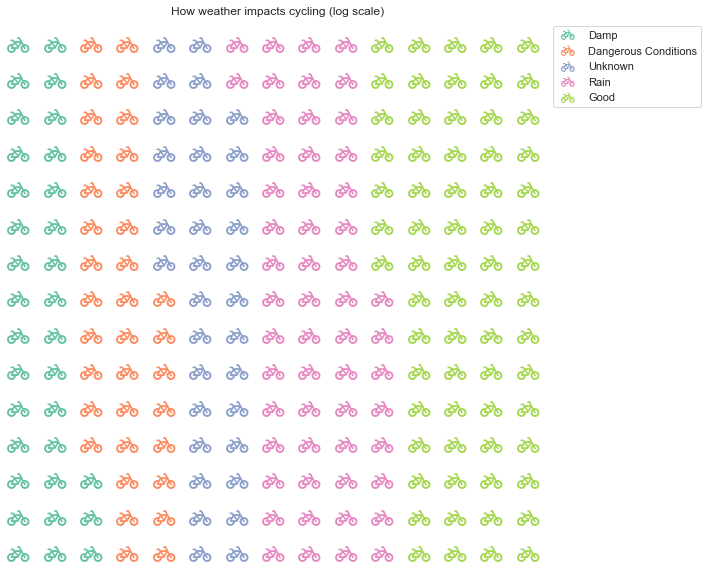

In [64]:
# Plot Waffle Chart
# Change to log scale
data = {'Damp': math.log(683), 'Dangerous Conditions': math.log(927), 'Unknown': math.log(982), 'Rain': math.log(51835), 
        'Good': math.log(536883)}
fig = plt.figure(FigureClass = Waffle, rows = 15, columns = 15, values = data, 
                 title = {'label': 'How weather impacts cycling (log scale)'}, 
                 legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
                 figsize = (10,15), icons='bicycle', icon_size=18, icon_legend=True)

# Takes time to plot
# May not be doable when all the dataframes are merged
# Ask Kevin to see if he can prettify

In [62]:
# Plot Stacked Bar Chart as an alternative maybe?
# For Kevin

In [ ]:
# Explore combination of other variables